In [1]:
import rebound
import time
import matplotlib.pyplot as plt
import numpy as np
import sys

# configuring plots
#plt.rc('text', usetex=True)             # use LaTeX for text
plt.rc('font', family='serif')          # use serif font
plt.rcParams.update({'font.size': 16})  # increase font size

# https://rebound.readthedocs.io/en/latest/ipython_examples/HighOrderSymplectic/

In [2]:
def energy_fn(sim):
    """ Calculate energy per unit mass as shown in p. 77 of Tremaine's book
    
    Args:
        sim::rebound.simulation.Simulation
            Rebound simulation object

    Returns:
        energy::float
            Energy per unit mass
    """
   
    e_kin = 0.
    e_pot = 0.
    
    for i, pi in enumerate(sim.particles):
        e_kin += 0.5 * pi.m * (pi.vx*pi.vx + pi.vy*pi.vy + pi.vz*pi.vz) 
        for j, pj in enumerate(sim.particles):
        
            if i > j:
                dx = pi.x - pj.x
                dy = pi.y - pj.y
                dz = pi.z - pj.z
                e_pot += - sim.G * pi.m * pj.m / np.sqrt(dx*dx + dy*dy + dz*dz)
    
    return e_kin + e_pot



In [48]:
integrators = ['whfast', 'ias15']
eccentricity = [0., 0.9, 0.99]

sim = rebound.Simulation()

sim.add(m=1.)                # central object
sim.add(m=1e-3, a=1, e=0.0) # hot jupiter
sim.add(m=1e-3, a=100, e=0.0) # companion

def measure_energy(sim):
    Nsamples = 1000
    tmax = 2.*np.pi*1e2 # 100 years
    t_samples = tmax*np.sort(np.random.random(Nsamples))
    E0 = sim.calculate_energy() # initial energy
    #E0 = energy_fn(sim) # initial energy
    Emax = 0. # maximum energy error
    for t in t_samples:
        # we do not want to change the timestep to reach t exactly, thus 
        # we need to set exact_finish_time=False and slighlty overshoot.
        sim.integrate(t,exact_finish_time=False) 
        E = sim.calculate_energy()
        #E = energy_fn(sim)
        Emax = max(Emax, np.abs((E-E0)/E0))
    return Emax

def integrate(sim, integrator, ecc):
    sim_run = sim.copy() # make a copy of the simulation so we don't need to set a new one up every time
    sim_run.particles[1].e = ecc
    sim_run.integrator = integrator
    sim_run.dt = dt
    if integrator == 'ias15':
        #sim_run.ri_ias15.epsilon = 0
        sim_run.ri_ias15.min_dt = dt
    if integrator == 'whfast':
        sim_run.ri_whfast.safe_mode = False

    return measure_energy(sim_run)

N_dt_samples = 100
dt_samples = sim.particles[1].P * np.logspace(-5,0.,N_dt_samples)
N_simulations = int(len(integrators) * len(eccentricity))
time_to_integrate = np.zeros(N_simulations)

relE_error = np.zeros((N_simulations, N_dt_samples))

### whfast ###

for i, integrator in enumerate(integrators):
    for e, ecc in enumerate(eccentricity):
        
        print(integrator + ', ecc =', ecc)
            
        start = time.time()
        for j, dt in enumerate(dt_samples):
            relE_error[len(eccentricity)*i+e,j] = integrate(sim, integrator, ecc)

        end = time.time()

        time_to_integrate[len(eccentricity)*i+e] = np.round(end - start, 1)


whfast, ecc = 0.0
whfast, ecc = 0.9
whfast, ecc = 0.99
ias15, ecc = 0.0


/home/michaelpoon/anaconda3/envs/AST1500/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


ias15, ecc = 0.9
ias15, ecc = 0.99


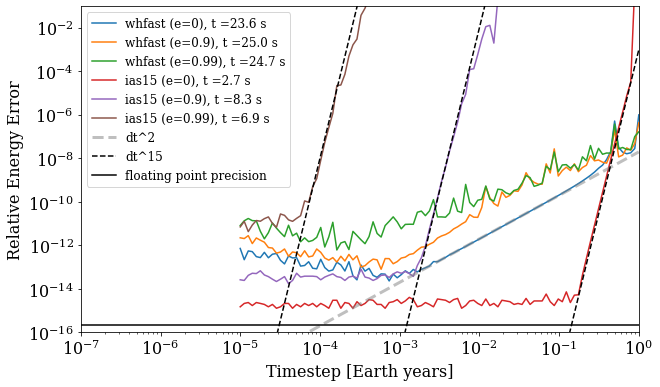

In [152]:
# 100 inner orbits

timestep = dt_samples/sim.particles[1].P

plt.figure(figsize=(10,6))
plt.plot(timestep,relE_error[0],label='whfast (e=0), t =' + str(time_to_integrate[0]) + ' s')
plt.plot(timestep,relE_error[1],label='whfast (e=0.9), t =' + str(time_to_integrate[1]) + ' s')
plt.plot(timestep,relE_error[2],label='whfast (e=0.99), t =' + str(time_to_integrate[2]) + ' s')
plt.plot(timestep,relE_error[3],label='ias15 (e=0), t =' + str(time_to_integrate[3]) + ' s')
plt.plot(timestep,relE_error[4],label='ias15 (e=0.9), t =' + str(time_to_integrate[4]) + ' s')
plt.plot(timestep,relE_error[5],label='ias15 (e=0.99), t =' + str(time_to_integrate[5]) + ' s')

#plt.plot(timestep,timestep**15,ls = '--', label='dt^5, t =' + str(time_to_integrate[0]) + ' s')
plt.plot(timestep,2e-8*timestep**2,ls = '--', c='grey', lw=3, alpha=0.5, label='dt^2')


plt.plot(timestep,1e-3*timestep**15,ls = '--', c='black', label='dt^15')
plt.plot(timestep,1e28*timestep**15,ls = '--', c='black')
plt.plot(timestep,1e52*timestep**15,ls = '--', c='black')

plt.axhline(sys.float_info.epsilon, label='floating point precision', c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-7, 1e0)
plt.ylim(1e-16, 1e-1)
plt.xlabel('Timestep [Earth years]')
plt.ylabel('Relative Energy Error')
plt.legend(fontsize=12, loc='upper left')
plt.savefig('EccentricWH_motivation.pdf')
plt.show()